In [ ]:
# Importing the necessary module to mount Google Drive
from google.colab import drive

# Mounting Google Drive to access files from Google Drive
# This will prompt you to authorize access to your Google Drive account
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries

!pip install transformers  # Installs the transformers library for NLP models
!pip install imageio       # Installs imageio to handle image files (e.g., GIFs)
!pip install gtts          # Installs Google Text-to-Speech API for text-to-speech
!pip install bert-score    # Installs the BERTScore metric library for evaluation
!pip install nltk          # Installs the NLTK library for natural language processing tasks
!pip install rouge-score   # Installs the Rouge score package for evaluation metrics
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2b0f3d32d7f3821147ea43205f5514479b35a6c6cac55023881f4110c95777d3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=842786404520aaf44a483128df6a930b0ea18c18a97a5419b0284907dc7859c9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip show torch

Name: torch
Version: 2.5.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, bert-score, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


In [ ]:
# Load the BLIP Model and Data from .pth Files
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from lime import lime_image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np

# Load the model's state dictionary
model_path = '/content/drive/My Drive/Models/blip_model.pth'
data_path = '/content/drive/My Drive/Models/data.pth'

# Initialize BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda' if torch.cuda.is_available() else 'cpu')

# Load model weights (assuming `model_path` contains only model weights)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load the image data (assuming it’s saved as a tensor or PIL image in the .pth file)
image_data = torch.load(data_path)  # Load saved image data, or convert if needed

# Check if image_data is a dictionary and extract the image
# Assuming 'processed_gifs' contains a list of images
if isinstance(image_data, dict) and "processed_gifs" in image_data:
    # Access the first image in the list (you might need to adjust the index)
    image = image_data["processed_gifs"][0]
    # If each element in the list is another dictionary (contains the frames of GIF?)
    # we will assume image is stored with key 'image' for this example.
    if isinstance(image, dict) and 'image' in image:
        image = image['image']
else:
    image = image_data  # If not a dictionary, assume it's the image data directly

# Convert the image to a NumPy array and ensure it has the correct data type
if isinstance(image, torch.Tensor):
    image = image.cpu().numpy()
elif isinstance(image, Image.Image):
    image = np.array(image)
# Ensure the image is in the correct format and data type
# Check if image data is numeric and handle potential errors
if image.dtype == object:  # Check if the dtype is 'object'
    try:
        # Attempt to convert to numeric type, assuming it's an array of objects
        image = image.astype(np.float64)
    except (TypeError, ValueError):
        print("Error: Image data contains non-numeric or incompatible elements.")
        print("Image data type:", image.dtype)
        print("Image data shape:", image.shape)
        print("Image data sample:", image[0] if image.size > 0 else "Empty")
        raise  # Re-raise the exception to stop execution

# If image is not in the format (H, W, 3), convert it
if image.ndim == 2:  # if grayscale
    image = np.stack((image,) * 3, axis=-1)  # convert to RGB
elif image.shape[0] == 3 and image.ndim == 3:  # if channels-first
    image = image.transpose(1, 2, 0)  # convert to channels-last
# Now you can proceed with LIME

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-10-59a888a12ddc>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

In [ ]:
# Define the prediction function for LIME
def blip_predict_2(images):
    scores = []
    for img in images:
        # Ensure img is a NumPy array and has the correct shape
        if isinstance(img, np.ndarray):
            if img.ndim == 2:  # Convert grayscale to RGB
                img = np.stack((img,) * 3, axis=-1)
            img = Image.fromarray(img.astype('uint8'))  # Convert array back to a PIL Image if necessary

        # Process the image
        inputs = processor(images=img, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu')

        # Generate caption using BLIP
        with torch.no_grad():
            output = model.generate(inputs["pixel_values"])
            caption = processor.decode(output[0], skip_special_tokens=True)

        # Use the length of the caption as a proxy score for interpretability
        scores.append([len(caption)])
    return np.array(scores)

In [ ]:
# Define the Prediction Function for LIME

def blip_predict(images):
    captions = []
    for img in images:
        # Process the image
        inputs = processor(images=img, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu') # Move inputs to the appropriate device

        # Generate caption
        with torch.no_grad():  # Disable gradient calculation for inference
            output = model.generate(inputs["pixel_values"])
            caption = processor.decode(output[0], skip_special_tokens=True)

        captions.append(caption)
    return captions


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


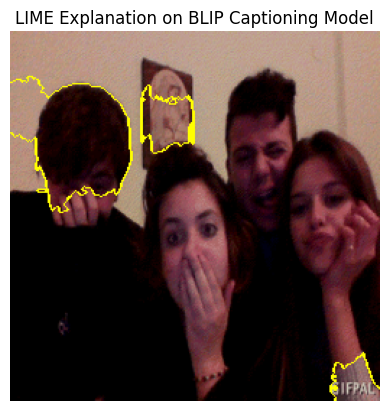

In [ ]:
# Apply LIME for Interpretability

# Initialize the LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Select a single image from the image array
# Assuming image is a 4D array (batch, height, width, channels)
single_image = image[0]  # Select the first image from the batch

# Explain the prediction using LIME with the single image
explanation = explainer.explain_instance(
    single_image,  # Use the single image here
    blip_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # Number of perturbed samples to generate
)

# Visualize the explanation by overlaying it on the image
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,  # Number of features (segments) to highlight
    hide_rest=False
)

# Display the LIME result with highlighted regions
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation on BLIP Captioning Model")
plt.show()